#### ДЗ_34  - определение возраста при помощи ансамбля моделей и мехнизма внимания
#### Татур А.А.
##### 09.04.2023

#### Взять за основу любое предыдущее задание и подключить слой внимания

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, AveragePooling2D,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D,\
                                    MultiHeadAttention, Input
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

from tensorflow.keras.layers import Concatenate, Input

pd.set_option('display.max_rows', 30)

from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.utils import plot_model 

import gc

In [2]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### 01. Загружаем файлы. Формируем датайфрейм ссылка/возраст для фалов с лицами. Сохраняем в .csv файл

In [3]:
df = pd.DataFrame() ### Создаем пустой Dataframe

for file_name in tqdm(os.listdir('D:\\UTKFace\\')):
    #формируем ссылку на изображение
    link = 'D:\\UTKFace\\' + file_name
    
    name = file_name[:-4] #убираем расширение файла из имени
    age = name.split('_')[0] # делаем сплит по нижнему подчеркиванию и выбираем дату
            
    #формируем временный датафрейм
    data = pd.DataFrame({'link': [str(link)],
                         'age': [int(age)]})
            #Делаем конкатенацию с основным датафреймом.
    df = pd.concat([df,data], axis=0)

df.to_csv('data_UTK.csv',
          index=False) #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

100%|██████████| 23708/23708 [00:14<00:00, 1631.08it/s]


#### 01.2. Загрузим полученный датасет

In [3]:
df = pd.read_csv ('data_UTK.csv')

In [4]:
df

,link,age
0,D:\UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,D:\UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,D:\UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,D:\UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,D:\UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,D:\UTKFace\9_1_3_20161220222856346.jpg.chip.jpg,9
23704,D:\UTKFace\9_1_3_20170104222949455.jpg.chip.jpg,9
23705,D:\UTKFace\9_1_4_20170103200637399.jpg.chip.jpg,9
23706,D:\UTKFace\9_1_4_20170103200814791.jpg.chip.jpg,9


#### Выведем рандомные 25 изображений из полученного списка

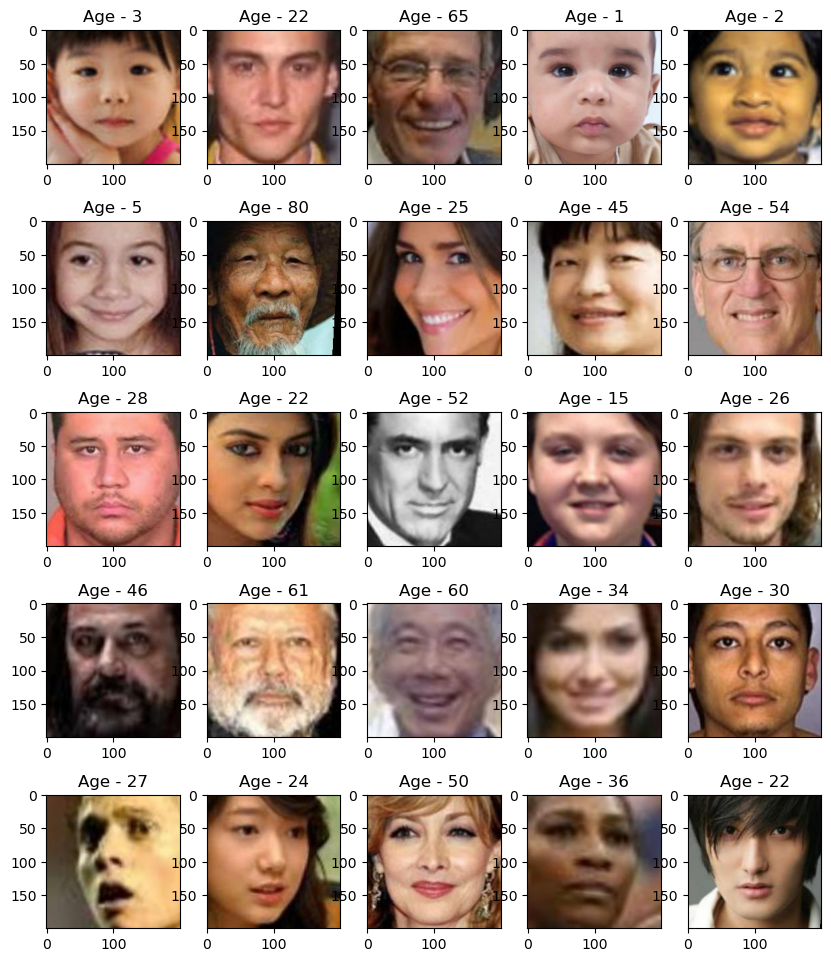

In [6]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[0])
    title = 'Age - ' + str(link[1])
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### 02. Загружаем сет. Формируем тренировочный и тестовый набор

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

#### 03. Создаем генератор

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [6]:
TARGET_SIZE = (128,128)
BATCH_SIZE = 12

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 13277 validated image filenames.
Found 5689 validated image filenames.
Found 4742 validated image filenames.


#### 03. Создаем архитектуру собственной модели

In [ ]:
input_layer = Input(shape=(128,128,3))

conv_layer1 = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer1)

conv_layer2 = Conv2D(128, (3,3), padding='same', activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer2)

conv_layer3 = Conv2D(256, (3,3), padding='same', activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer3)

conv_layer4 = Conv2D(512, (3,3), padding='same', activation='relu')(max_pool3)
max_pool4 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer4)

conv_layer5 = Conv2D(512, (3,3), padding='same', activation='relu')(max_pool4)
max_pool5 = MaxPooling2D(pool_size=(2,2), strides=2)(conv_layer5)

global_max_pool = GlobalMaxPool2D()(max_pool5)

dense_1 = Dense(1000, activation='relu')(global_max_pool)
drop_1 = Dropout(0.7)(dense_1)

multi_head = MultiHeadAttention(num_heads=12, key_dim=256, attention_axes=(0, 1))(drop_1, drop_1)
drop_2 = Dropout(0.5)(multi_head)

output_layer = Dense(1, activation='linear')(drop_2)


model_conv = Model(inputs=input_layer, outputs=output_layer)

In [11]:
model_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                              

#### 04. Обучаем собственную модель

Epoch 1/30
830/830 [==============================] - 49s 52ms/step - loss: 432.0027 - mae: 15.9706 - val_loss: 395.1651 - val_mae: 15.5025 - lr: 1.0000e-04
Epoch 2/30
830/830 [==============================] - 42s 50ms/step - loss: 352.1742 - mae: 14.3904 - val_loss: 237.7701 - val_mae: 11.7002 - lr: 1.0000e-04
Epoch 3/30
830/830 [==============================] - 42s 50ms/step - loss: 211.8986 - mae: 11.1243 - val_loss: 169.3001 - val_mae: 9.8995 - lr: 1.0000e-04
Epoch 4/30
830/830 [==============================] - 42s 51ms/step - loss: 161.3483 - mae: 9.5100 - val_loss: 134.2809 - val_mae: 8.5238 - lr: 1.0000e-04
Epoch 5/30
830/830 [==============================] - 42s 50ms/step - loss: 129.4276 - mae: 8.4342 - val_loss: 137.6224 - val_mae: 9.3169 - lr: 1.0000e-04
Epoch 6/30
830/830 [==============================] - 42s 50ms/step - loss: 110.6560 - mae: 7.7879 - val_loss: 109.5880 - val_mae: 7.8005 - lr: 1.0000e-04
Epoch 7/30
830/830 [==============================] - 42s 50ms/st

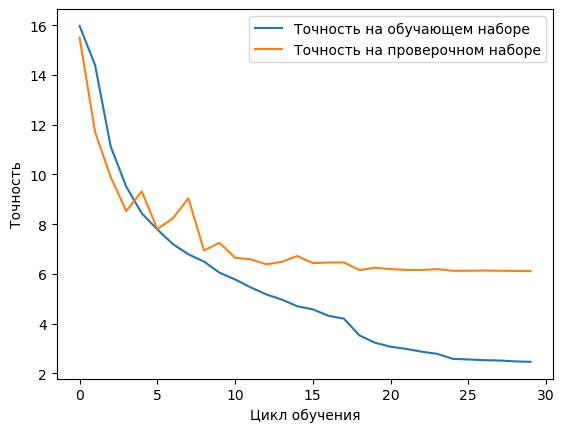

In [12]:
model_conv.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("own_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_own = model_conv.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=30)

test_val_graph (history_own,'mae','val_mae')

In [13]:
del model_conv
gc.collect()

3983

In [14]:
model_conv = load_model("own_model.h5")

In [15]:
model_conv.evaluate (test_generator)

297/297 [==============================] - 6s 21ms/step - loss: 74.9210 - mae: 6.0582


[74.92098236083984, 6.058166980743408]

In [16]:
del model_conv
gc.collect()

2511

#### 05. Берем предобученную модель VGG16 (отключаем все слои кроме 3-х последних и добавляем собственные)

In [ ]:
vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False) 

for i in vgg16.layers[:-3]:
    i.trainable = False 

# build model 
input = vgg16.layers[-1].output # input is the last output from vgg16 

x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)

x = MultiHeadAttention(num_heads=12, key_dim=256, attention_axes=(0, 1))(x, x)
x = Dropout(0.5)(x)

output = Dense(1, activation='linear')(x) 

# create the model 
vgg16_model = Model(vgg16.input, output, name='VGG16_Model')

In [18]:
vgg16_model.summary()

Model: "VGG16_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

Epoch 1/20
830/830 [==============================] - 48s 55ms/step - loss: 224.9731 - mae: 10.9275 - val_loss: 120.3923 - val_mae: 8.1914 - lr: 5.0000e-04
Epoch 2/20
830/830 [==============================] - 44s 53ms/step - loss: 113.5183 - mae: 7.8397 - val_loss: 97.2732 - val_mae: 7.2226 - lr: 5.0000e-04
Epoch 3/20
830/830 [==============================] - 44s 53ms/step - loss: 98.1695 - mae: 7.3131 - val_loss: 109.2879 - val_mae: 7.8581 - lr: 5.0000e-04
Epoch 4/20
830/830 [==============================] - 44s 53ms/step - loss: 86.3487 - mae: 6.8350 - val_loss: 82.7520 - val_mae: 6.5331 - lr: 5.0000e-04
Epoch 5/20
830/830 [==============================] - 44s 53ms/step - loss: 77.1343 - mae: 6.4935 - val_loss: 79.6612 - val_mae: 6.4160 - lr: 5.0000e-04
Epoch 6/20
830/830 [==============================] - 44s 53ms/step - loss: 70.7023 - mae: 6.2207 - val_loss: 81.6789 - val_mae: 6.4208 - lr: 5.0000e-04
Epoch 7/20
830/830 [==============================] - 44s 53ms/step - loss: 6

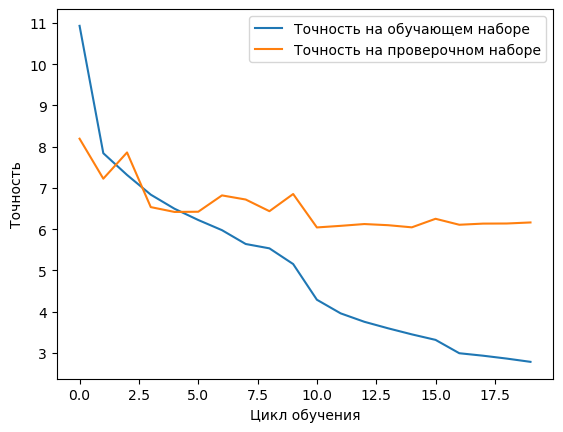

In [19]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

checkpoint_cb_conv = ModelCheckpoint("vgg16_model.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')

history_vgg16 = vgg16_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=20)

test_val_graph (history_vgg16,'mae','val_mae')

In [53]:
del vgg16_model
gc.collect()

7802

In [ ]:
vgg16_model = load_model("vgg16_model.h5")

In [ ]:
vgg16_model.evaluate (test_generator)

In [ ]:
del model_vgg16
gc.collect()

##### 06. Конкатенируем модели в одну единую

In [21]:
del vgg16_model
del model_conv
gc.collect()

3619

In [9]:
model_conv = load_model("own_model.h5")
vgg16_model = load_model("vgg16_model.h5")

In [10]:
models = [model_conv, vgg16_model]

input = Input(shape=(128, 128, 3))

outputs = [model(input) for model in models]

# contenate the ouputs
x = Concatenate()(outputs) 

# add further layers
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x) 

output = Dense(1, activation='linear')(x) # output layer

# create concatenated model
conc_model = Model(input, output)

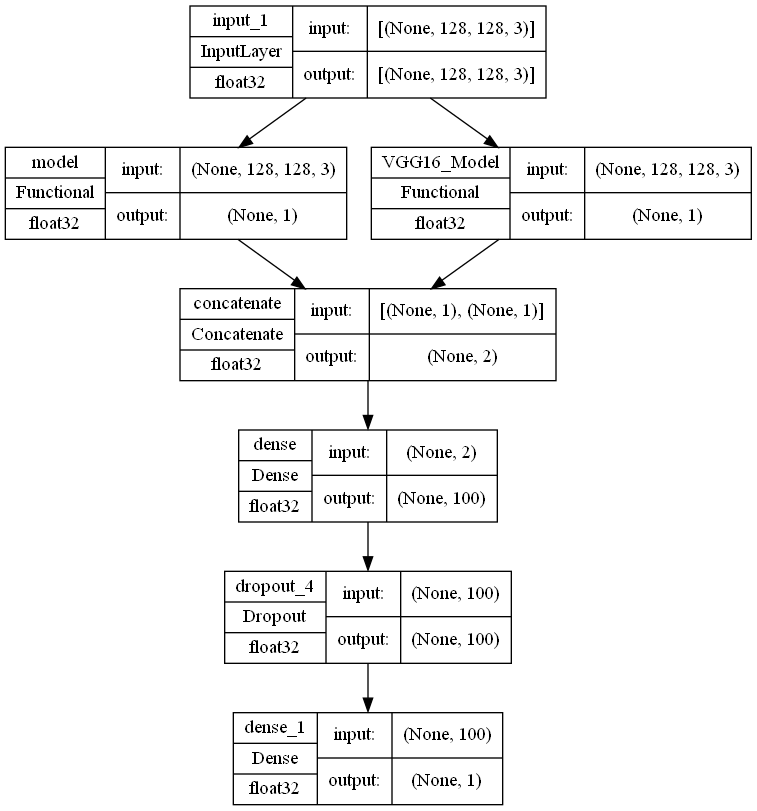

In [11]:
plot_model(conc_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [12]:
conc_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1)            16723001    ['input_1[0][0]']                
                                                                                                  
 VGG16_Model (Functional)       (None, 1)            35206905    ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['model[0][0]',              

#### 07. Обучаем полученную модель

In [13]:
conc_model.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

Epoch 1/40
1107/1107 [==============================] - ETA: 0s - loss: 475.7266 - mae: 15.4407

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 113s 95ms/step - loss: 475.7266 - mae: 15.4407 - val_loss: 123.4269 - val_mae: 8.0373 - lr: 5.0000e-05
Epoch 2/40
1107/1107 [==============================] - ETA: 0s - loss: 168.3026 - mae: 9.3189

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 168.3026 - mae: 9.3189 - val_loss: 96.5797 - val_mae: 6.9165 - lr: 5.0000e-05
Epoch 3/40
1107/1107 [==============================] - ETA: 0s - loss: 127.5463 - mae: 8.0826

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 127.5463 - mae: 8.0826 - val_loss: 83.9440 - val_mae: 6.3956 - lr: 5.0000e-05
Epoch 4/40
1107/1107 [==============================] - ETA: 0s - loss: 101.6317 - mae: 7.2738

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 101.6317 - mae: 7.2738 - val_loss: 70.8324 - val_mae: 6.0124 - lr: 5.0000e-05
Epoch 5/40
1107/1107 [==============================] - ETA: 0s - loss: 88.2321 - mae: 6.7817

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 88.2321 - mae: 6.7817 - val_loss: 67.5426 - val_mae: 5.8666 - lr: 5.0000e-05
Epoch 6/40
1107/1107 [==============================] - 91s 82ms/step - loss: 77.0421 - mae: 6.3463 - val_loss: 69.3271 - val_mae: 6.0312 - lr: 5.0000e-05
Epoch 7/40
1107/1107 [==============================] - 91s 82ms/step - loss: 75.9984 - mae: 6.2781 - val_loss: 79.0648 - val_mae: 6.2969 - lr: 5.0000e-05
Epoch 8/40
1107/1107 [==============================] - 91s 82ms/step - loss: 66.8562 - mae: 5.9455 - val_loss: 68.1625 - val_mae: 5.9185 - lr: 5.0000e-05
Epoch 9/40
1107/1107 [==============================] - ETA: 0s - loss: 66.0925 - mae: 5.8506

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 66.0925 - mae: 5.8506 - val_loss: 67.1629 - val_mae: 5.8608 - lr: 5.0000e-05
Epoch 10/40
1107/1107 [==============================] - 91s 82ms/step - loss: 63.6352 - mae: 5.7619 - val_loss: 71.1757 - val_mae: 6.0036 - lr: 5.0000e-05
Epoch 11/40
1107/1107 [==============================] - 91s 82ms/step - loss: 61.7180 - mae: 5.6547 - val_loss: 71.8100 - val_mae: 6.0517 - lr: 5.0000e-05
Epoch 12/40
1107/1107 [==============================] - ETA: 0s - loss: 60.6799 - mae: 5.5900

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 60.6799 - mae: 5.5900 - val_loss: 66.2099 - val_mae: 5.8249 - lr: 5.0000e-05
Epoch 13/40
1107/1107 [==============================] - 91s 82ms/step - loss: 61.1272 - mae: 5.6011 - val_loss: 65.8513 - val_mae: 5.8276 - lr: 5.0000e-05
Epoch 14/40
1107/1107 [==============================] - 91s 82ms/step - loss: 57.7577 - mae: 5.4862 - val_loss: 72.1759 - val_mae: 6.0637 - lr: 5.0000e-05
Epoch 15/40
1107/1107 [==============================] - 91s 82ms/step - loss: 57.7246 - mae: 5.4746 - val_loss: 67.3374 - val_mae: 5.8327 - lr: 5.0000e-05
Epoch 16/40
1107/1107 [==============================] - ETA: 0s - loss: 57.5907 - mae: 5.4637

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 57.5907 - mae: 5.4637 - val_loss: 63.9267 - val_mae: 5.7739 - lr: 5.0000e-05
Epoch 17/40
1107/1107 [==============================] - 91s 82ms/step - loss: 57.1567 - mae: 5.3980 - val_loss: 68.2661 - val_mae: 5.9392 - lr: 5.0000e-05
Epoch 18/40
1107/1107 [==============================] - 91s 82ms/step - loss: 56.0763 - mae: 5.4039 - val_loss: 70.6024 - val_mae: 5.9176 - lr: 5.0000e-05
Epoch 19/40
1107/1107 [==============================] - ETA: 0s - loss: 54.7133 - mae: 5.3237

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 54.7133 - mae: 5.3237 - val_loss: 64.7780 - val_mae: 5.7316 - lr: 5.0000e-05
Epoch 20/40
1107/1107 [==============================] - 91s 82ms/step - loss: 55.0639 - mae: 5.3366 - val_loss: 68.1884 - val_mae: 5.8508 - lr: 5.0000e-05
Epoch 21/40
1107/1107 [==============================] - 91s 82ms/step - loss: 54.2488 - mae: 5.2840 - val_loss: 72.1368 - val_mae: 5.9400 - lr: 5.0000e-05
Epoch 22/40
1107/1107 [==============================] - 91s 82ms/step - loss: 55.3239 - mae: 5.3222 - val_loss: 66.8273 - val_mae: 5.7863 - lr: 5.0000e-05
Epoch 23/40
1107/1107 [==============================] - 91s 82ms/step - loss: 53.3183 - mae: 5.2661 - val_loss: 72.5741 - val_mae: 6.0779 - lr: 5.0000e-05
Epoch 24/40
1107/1107 [==============================] - 91s 82ms/step - loss: 53.5079 - mae: 5.2374 - val_loss: 68.0286 - val_mae: 5.8371 - lr: 5.0000e-05
Epoch 25/40
1107/1107 [==============================] - ETA: 0s - loss: 50

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 100s 91ms/step - loss: 50.6515 - mae: 5.0428 - val_loss: 63.9396 - val_mae: 5.6634 - lr: 1.0000e-05
Epoch 26/40
1107/1107 [==============================] - 91s 82ms/step - loss: 48.3685 - mae: 4.9147 - val_loss: 68.2969 - val_mae: 5.8227 - lr: 1.0000e-05
Epoch 27/40
1107/1107 [==============================] - 91s 82ms/step - loss: 48.7114 - mae: 4.9855 - val_loss: 68.2438 - val_mae: 5.8163 - lr: 1.0000e-05
Epoch 28/40
1107/1107 [==============================] - 91s 82ms/step - loss: 48.4551 - mae: 4.9212 - val_loss: 68.1121 - val_mae: 5.8013 - lr: 1.0000e-05
Epoch 29/40
1107/1107 [==============================] - 91s 82ms/step - loss: 48.2404 - mae: 4.8890 - val_loss: 65.7880 - val_mae: 5.7389 - lr: 1.0000e-05
Epoch 30/40
1107/1107 [==============================] - ETA: 0s - loss: 47.1690 - mae: 4.8855

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 47.1690 - mae: 4.8855 - val_loss: 64.4580 - val_mae: 5.6596 - lr: 1.0000e-05
Epoch 31/40
1107/1107 [==============================] - ETA: 0s - loss: 46.9119 - mae: 4.8420

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 46.9119 - mae: 4.8420 - val_loss: 64.0640 - val_mae: 5.6527 - lr: 1.0000e-05
Epoch 32/40
1107/1107 [==============================] - 91s 82ms/step - loss: 47.4679 - mae: 4.8828 - val_loss: 65.1448 - val_mae: 5.7069 - lr: 1.0000e-05
Epoch 33/40
1107/1107 [==============================] - 91s 82ms/step - loss: 47.2541 - mae: 4.8471 - val_loss: 64.9733 - val_mae: 5.6797 - lr: 1.0000e-05
Epoch 34/40
1107/1107 [==============================] - ETA: 0s - loss: 46.0633 - mae: 4.7985

INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


INFO:tensorflow:Assets written to: new_one_with_att_model.tf\assets


1107/1107 [==============================] - 101s 91ms/step - loss: 46.0633 - mae: 4.7985 - val_loss: 62.9795 - val_mae: 5.6199 - lr: 1.0000e-05
Epoch 35/40
1107/1107 [==============================] - 91s 82ms/step - loss: 46.8557 - mae: 4.8222 - val_loss: 63.6026 - val_mae: 5.6318 - lr: 1.0000e-05
Epoch 36/40
1107/1107 [==============================] - 91s 82ms/step - loss: 47.1446 - mae: 4.8260 - val_loss: 63.5758 - val_mae: 5.6297 - lr: 1.0000e-05
Epoch 37/40
1107/1107 [==============================] - 91s 82ms/step - loss: 45.3303 - mae: 4.7619 - val_loss: 64.4515 - val_mae: 5.6678 - lr: 1.0000e-05
Epoch 38/40
1107/1107 [==============================] - 91s 82ms/step - loss: 45.5815 - mae: 4.7692 - val_loss: 70.2510 - val_mae: 5.8625 - lr: 1.0000e-05
Epoch 39/40
1107/1107 [==============================] - 91s 82ms/step - loss: 45.3168 - mae: 4.7796 - val_loss: 68.0023 - val_mae: 5.8232 - lr: 1.0000e-05
Epoch 40/40
1107/1107 [==============================] - 91s 82ms/step - lo

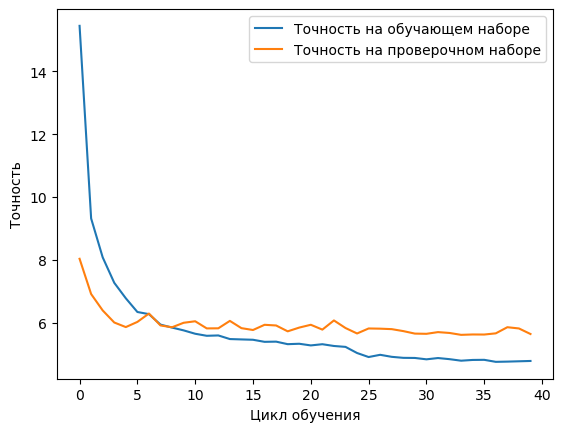

In [14]:
checkpoint_cb_conv = ModelCheckpoint("new_one_with_att_model.tf", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, 
                                 patience=5,  
                                 monitor = 'val_mae')


history_conc  = conc_model.fit(train_generator,
                           validation_data=valid_generator,
                           callbacks=[checkpoint_cb_conv,lr_scheduler],
                           epochs=40)

test_val_graph (history_conc,'mae','val_mae')


In [15]:
del conc_model
gc.collect()

61746

In [7]:
conc_model = load_model("new_one_with_att_model.tf")

In [8]:
conc_model.evaluate (test_generator)

396/396 [==============================] - 36s 79ms/step - loss: 65.0161 - mae: 5.5723


[65.01612091064453, 5.572312831878662]

#### 08. Пробуем построить предсказание по фотографиям c помощью собственной сети.

1/1 [==============================] - 0s 31ms/step


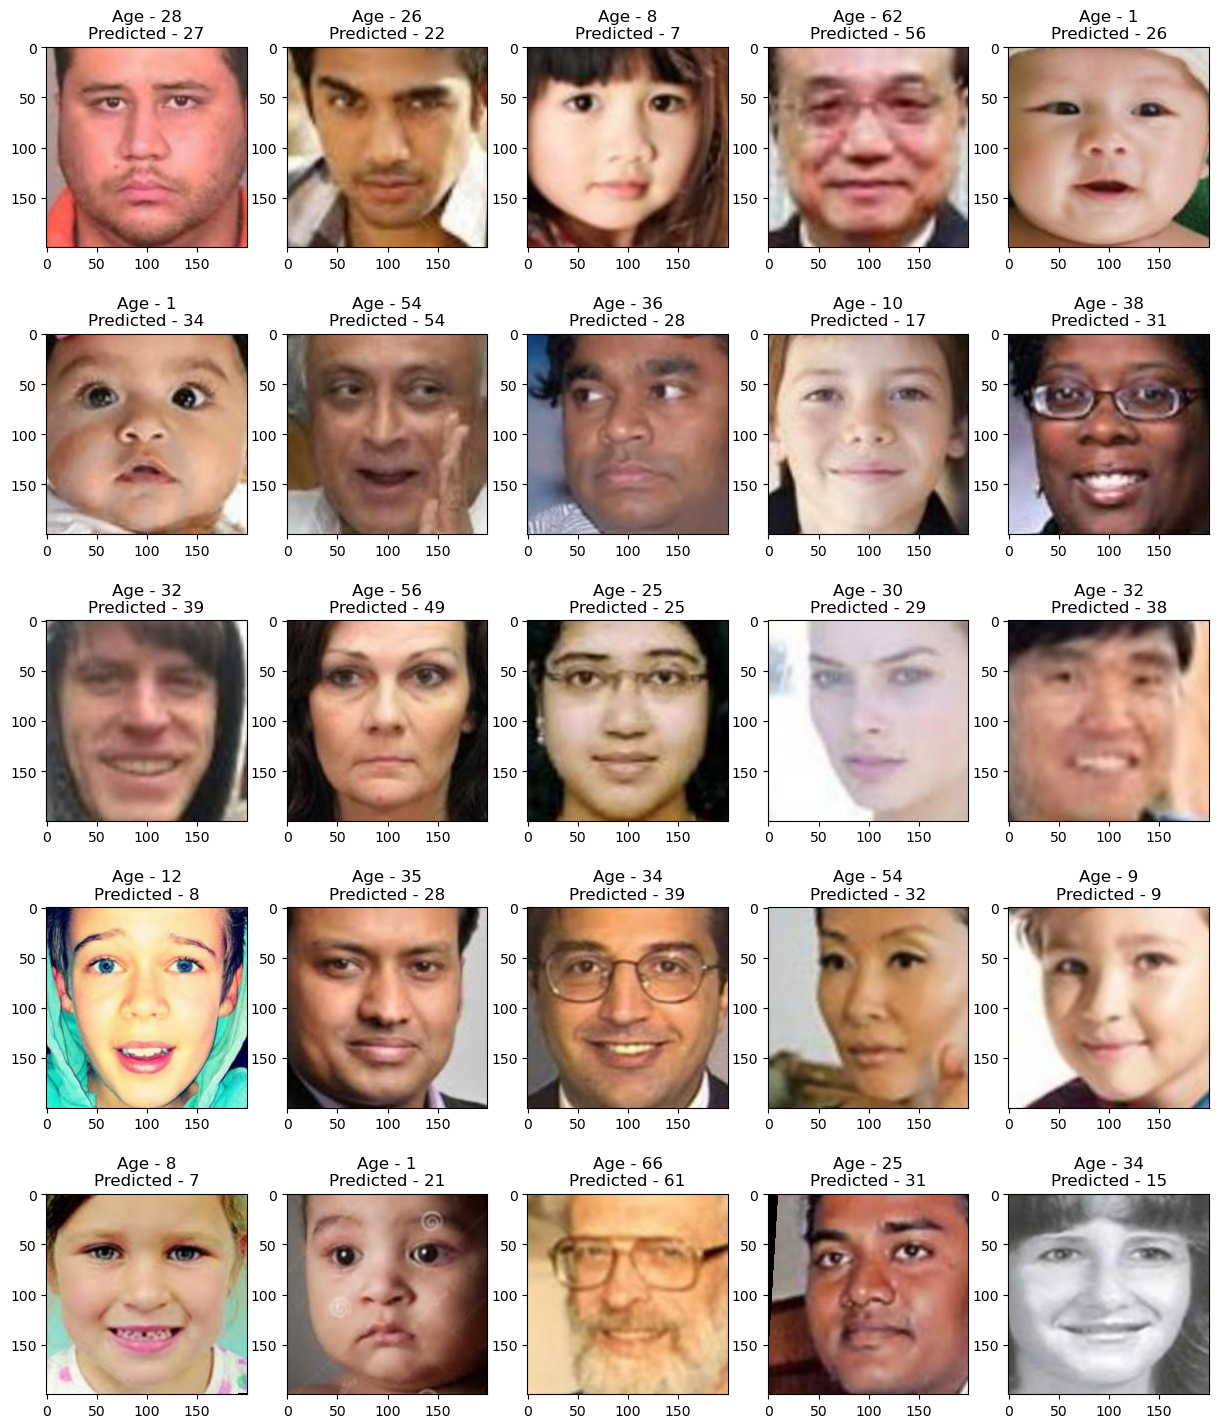

In [9]:
idx = np.random.randint (0,len(test),25)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    
    img_resized = cv2.resize (image, (128,128))/255 #,
    img_reshaped  = img_resized.reshape (1,128,128,3)
    predict = conc_model.predict(img_reshaped)[0][0];
    
    title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
    plt.title (title)
    plt.imshow(image, cmap='gray');

#### Выводы

Добавление слоя внимания в модели позволяет значительно повысить результат. Так в собственной модели без слоя внимания лучшее значение val_mae было 6.48, стало 6.11. VGG16 без слоя внимания продемонстрировало результат 6.14, со слоем внимания 6.04. Конкатенация моделей без внимания дало результат на тестовой выборке 6.04, со слоем внимания 5.57.